In [2]:
import drjit as dr
import mitsuba as mi
from ipywidgets import widgets
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
%matplotlib widget
# mi.set_variant('cuda_ad_rgb')
mi.set_variant('llvm_ad_rgb')
# mi.set_variant('scalar_rgb')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


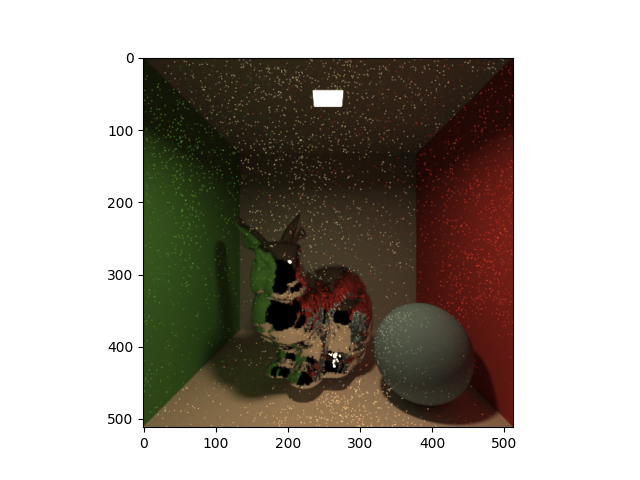

In [3]:
from mitsuba.scalar_rgb import Transform4f as T

config ={
    'type': 'scene',
    'integrator': {
        'type': 'path',
        'max_depth': 5,
    },
    'sensor':  {
        'type': 'perspective',
        'to_world': T.look_at(
                        origin=(0, 0, 2),
                        target=(0, 0, 0),
                        up=(0, 1, 0)
                    ),
        'fov': 70,
        'film': {
            'type': 'hdrfilm',
            'width': 512,
            'height': 512,
            'rfilter': { 'type': 'gaussian' },
            'sample_border': True
        },
        'sampler': {
            'type': 'independent',
            'sample_count': 64,
    },
    },
    'ceiling': {
        'type': 'obj',
        'filename': 'objects/cbox_ceiling.obj',
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
        }
    },
    'back': {
        'type': 'obj',
        'filename': 'objects/cbox_back.obj',
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.5, 0.5, 0.5) },
        }
    },
    'greenwall': {
        'type': 'obj',
        'filename': 'objects/cbox_greenwall.obj',
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.105421, 0.37798, 0.076425) },
        }
    },
    'redwall': {
        'type': 'obj',
        'filename': 'objects/cbox_redwall.obj',
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.570068, 0.0430135, 0.0443706) },
        }
    },
    'floor': {
        'type': 'obj',
        'filename': 'objects/cbox_floor.obj',
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.885809, 0.698859, 0.666422) },
        }
    },
    'bunny': {
        'type': 'ply',
        'filename': 'objects/bunny.ply',
        'to_world': T.translate([-0.1, -0.5, 0.0]).scale(7.5).rotate([0, 1, 0], 45),
            'bsdf': {
            'type': 'conductor',
            'eta': 0.2,
            'k': 3.0,
        },
    },
    # 'glass_sphere': {
    #     'type': 'obj',
    #     'filename': 'objects/sphere.obj',
    #     'to_world': T.translate([0.2, -0.7, 0.5]).scale(0.2),
    #     'bsdf': {
    #         'type': 'dielectric',

    #     },
    # },
    'plastic_sphere': {
        'type': 'obj',
        'filename': 'objects/sphere.obj',
        'to_world': T.translate([0.6, -0.7, 0.3]).scale(0.3),
        'bsdf': {
            'type': 'diffuse',
            'reflectance': { 'type': 'rgb', 'value': (0.2, 0.3, 0.4) },
        },
    },
    # 'mirror_sphere': {
    #     'type': 'obj',
    #     'filename': 'objects/sphere.obj',
    #     'to_world': T.translate([0.5, 0.5, -1.5]).scale(1.0),
    #     'bsdf': {
    #         'type': 'conductor',
    #     },
    # },
    # 'suzanne': {
    #     'type': 'ply',
    #     'to_world': T.translate([-0.9, -0.1, 0.1]).scale(0.2).rotate([0, 1, 0], 90).rotate([1, 0, 0], 45),
    #     'filename': 'objects/suzanne.ply',
    # },
    # 'teapot': {
    #     'type': 'ply',
    #     'filename': 'objects/teapot.ply',
    #     'to_world': T.translate([-0.5, -0.9, 0.5]).scale(0.1).rotate([-1, 0, 0], 90),
    #     'bsdf': {
    #         'type': 'diffuse',
    #         'reflectance': { 'type': 'rgb', 'value': (0.9, 0.1, 0.3) },
    #     },
    # },
    'light': {
        'type': 'obj',
        'filename': 'objects/cbox_luminaire.obj',
        'emitter': {
            'type': 'area',
            'radiance': {'type': 'rgb', 'value': [183, 139, 67]}
        },
        'to_world': T.translate([0, 0.4, 0.8]).scale(0.25)
    },
    # 'light_sphere': {
    #     'type': 'obj',
    #     'filename': 'objects/sphere.obj',
    #     'to_world': T.translate([0.0, -0.7, -1.0]).scale(0.1),
    #     'emitter': {
    #         'type': 'area',
    #         'radiance': {'type': 'rgb', 'value': [18, 13, 6]}
    #     },
    # },
}
def show(dict, spp=100):
    scene = mi.load_dict(dict)
    img_ref = mi.render(scene, seed=0, spp=spp)
    fig, ax = plt.subplots()
    ax.imshow(img_ref ** (1.0 / 2.2)) # srgb

show(config, spp=128)

In [8]:
rng = mi.PCG32()

In [14]:
type(rng.next_float32())

drjit.llvm.ad.Float

In [15]:
from random import random

class MySampler(mi.Sampler):

    def __init__(self, props):
        super().__init__(props)
        self.m_sample_count = props.get('sample_count', 4)
        # self.m_base_seed = props.get('seed', 0)
        self.props = props
        self.m_rng = mi.PCG32()

    def next_1d(self, active=True):
        return self.m_rng.next_float32(active)


    def next_2d(self, active=True):
        f1 = self.next_1d(active)
        f2 = self.next_1d(active)
        return mi.Point2f(f1, f2)

    def fork(self):
        return MySampler(self.props)
    
    def clone(self):
        return MySampler(self.props)
    
    def to_string(self):
        return ('MySampler[]')
# Register the sampler plugin
mi.register_sampler("mysampler", lambda props: MySampler(props))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


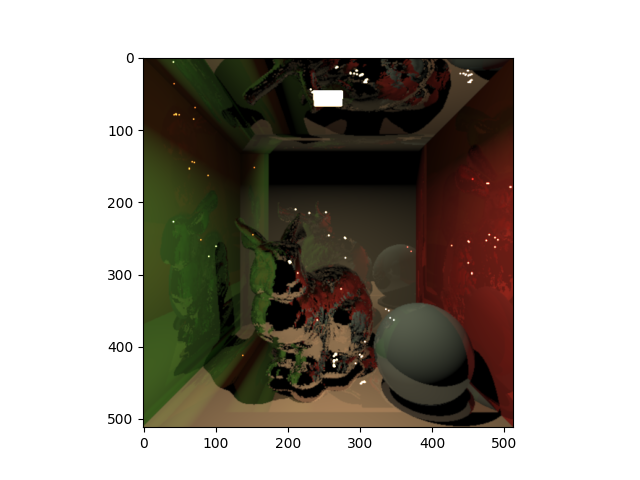

In [21]:
config['sensor']['sampler'] = {
    'type': 'mysampler',
    'sample_count': 64,
}

show(config, spp=128)

In [9]:
class MyBSDF(mi.BSDF):
    def __init__(self, props):
        super().__init__(props)

        # Read 'eta' and 'tint' properties from `props`
        self.eta = 1.33
        if props.has_property('eta'):
            self.eta = props['eta']

        self.tint = props['tint']

        # Set the BSDF flags
        reflection_flags   = mi.BSDFFlags.DeltaReflection   | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide
        transmission_flags = mi.BSDFFlags.DeltaTransmission | mi.BSDFFlags.FrontSide | mi.BSDFFlags.BackSide
        self.m_components  = [reflection_flags, transmission_flags]
        self.m_flags = reflection_flags | transmission_flags


    def sample(self, ctx, si, sample1, sample2, active):
        # print("sample")
        # Compute Fresnel terms
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)
        r_i, cos_theta_t, eta_it, eta_ti = mi.fresnel(cos_theta_i, self.eta)
        t_i = dr.maximum(1.0 - r_i, 0.0)

        # Pick between reflection and transmission
        selected_r = (sample1 <= r_i) & active

        # Fill up the BSDFSample struct
        bs = mi.BSDFSample3f()
        bs.pdf = dr.select(selected_r, r_i, t_i)
        bs.sampled_component = dr.select(selected_r, mi.UInt32(0), mi.UInt32(1))
        bs.sampled_type      = dr.select(selected_r, mi.UInt32(+mi.BSDFFlags.DeltaReflection),
                                                     mi.UInt32(+mi.BSDFFlags.DeltaTransmission))
        bs.wo = dr.select(selected_r,
                          mi.reflect(si.wi),
                          mi.refract(si.wi, cos_theta_t, eta_ti))
        bs.eta = dr.select(selected_r, 1.0, eta_it)

        # For reflection, tint based on the incident angle (more tint at grazing angle)
        value_r = dr.lerp(mi.Color3f(self.tint), mi.Color3f(1.0), dr.clamp(cos_theta_i, 0.0, 1.0))

        # For transmission, radiance must be scaled to account for the solid angle compression
        value_t = mi.Color3f(1.0) * dr.sqr(eta_ti)

        value = dr.select(selected_r, value_r, value_t)
        
        return (bs, value)

    def eval(self, ctx, si, wo, active):
        return 0.0

    def pdf(self, ctx, si, wo, active):
        return 0.0

    def eval_pdf(self, ctx, si, wo, active):
        return 0.0, 0.0

    def traverse(self, callback):
        callback.put_parameter('tint', self.tint, mi.ParamFlags.Differentiable)

    def parameters_changed(self, keys):
        print("there is nothing to do here")

    def to_string(self):
        return ('MyBSDF[\n'
                '    eta=%s,\n'
                '    tint=%s,\n'
                ']' % (self.eta, self.tint))

mi.register_bsdf("mybsdf", lambda props: MyBSDF(props))

class BBRRDF(mi.BSDF):
    def __init__(self, props: mi.Properties):
        mi.BSDF.__init__(self, props)
        assert(props.has_property('reflectance'))
        self.reflectance = props['reflectance']
        self.m_flags = mi.BSDFFlags.DiffuseReflection | mi.BSDFFlags.FrontSide
        self.m_components = [self.m_flags]

    def sample(self, ctx, si, sample1, sample2, active):
        bsdfSample = mi.BSDFSample3f()
        bsdfSample.wo = mi.warp.square_to_cosine_hemisphere(sample1)
        bsdfSample.pdf = mi.warp.square_to_cosine_hemisphere_pdf(bsdfSample.wo)
        bsdfSample.eta = 1.0
        bsdfSample.sampled_type = mi.UInt32(+mi.BSDFFlags.DiffuseReflection)
        bsdfSample.sampled_component = mi.UInt32(0)
        value = 0.0
        return (bsdfSample, value)

    def eval(self, ctx, si, wo, active):
        return 0.0

    def pdf(self, ctx, si, wo, active):
        if not ctx.is_enabled(mi.BSDFFlags.DiffuseReflection):
            return 0.0
        cos_theta_i = mi.Frame3f.cos_theta(si.wi)
        cos_theta_o = mi.Frame3f.cos_theta(wo)
        pdf = mi.warp.square_to_cosine_hemisphere_pdf(wo)
        return dr.select(cos_theta_i > 0.0 and cos_theta_o > 0.0, pdf, 0.0)

    def travarse(self, callback):
        callback.put_parameter()

    def to_string(self):
        return "BBRRDF[reflectance=%s]" % self.reflectance
    
mi.register_bsdf("bbrdf", lambda props: BBRRDF(props))



MyBSDF BSDFContext SurfaceInteraction3f Float Point2f Bool
MyBSDF BSDFContext SurfaceInteraction3f Float Point2f Bool
MyBSDF BSDFContext SurfaceInteraction3f Float Point2f Bool
MyBSDF BSDFContext SurfaceInteraction3f Float Point2f Bool
MyBSDF BSDFContext SurfaceInteraction3f Float Point2f Bool
MyBSDF BSDFContext SurfaceInteraction3f Float Point2f Bool


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


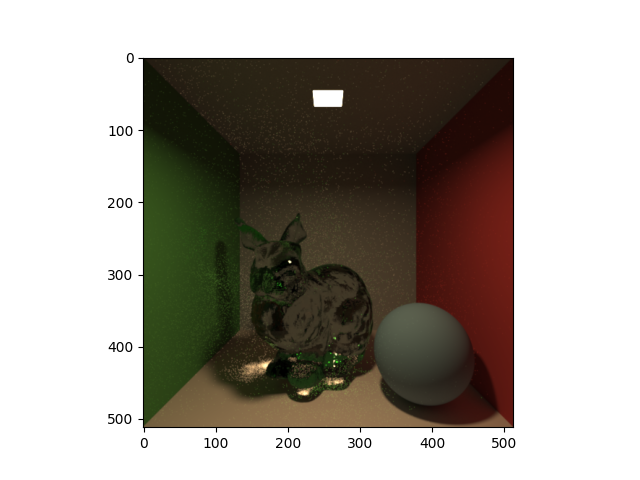

In [10]:
config['bunny']['bsdf'] =  {
    'type' : 'mybsdf',
    'tint' : [0.2, 0.9, 0.2],
    'eta' : 1.33
}

show(config, spp=1280)

In [6]:
class MyIntegrator(mi.SamplingIntegrator):
    def __init__(self, props=mi.Properties()):
        super().__init__(props)
        self.max_depth = props.get("max_depth", 5)
        self.rr_depth = props.get("rr_depth", 3)

    def sample(self, scene: mi.Scene, sampler: mi.Sampler, ray_: mi.RayDifferential3f, medium: mi.Medium = None, active: bool = True):
        print(self.__class__.__name__, scene.__class__.__name__, sampler.__class__.__name__, ray_.__class__.__name__, medium.__class__.__name__, active.__class__.__name__) 
        bsdf_ctx = mi.BSDFContext()

        ray = mi.Ray3f(ray_)
        depth = mi.UInt32(0)
        f = mi.Spectrum(1.)
        L = mi.Spectrum(0.)

        prev_si = dr.zeros(mi.SurfaceInteraction3f)

        loop = mi.Loop(name="Path Tracing", state=lambda: (
            sampler, ray, depth, f, L, active, prev_si))

        loop.set_max_iterations(self.max_depth)

        while loop(active):
            si: mi.SurfaceInteraction3f = scene.ray_intersect(
                ray, ray_flags=mi.RayFlags.All, coherent=dr.eq(depth, 0))

            bsdf: mi.BSDF = si.bsdf(ray)

            # Direct emission

            ds = mi.DirectionSample3f(scene, si=si, ref=prev_si)

            Le = f * ds.emitter.eval(si)

            active_next = (depth + 1 < self.max_depth) & si.is_valid()

            # BSDF Sampling
            bsdf_smaple, bsdf_val = bsdf.sample(
                bsdf_ctx, si, sampler.next_1d(), sampler.next_2d(), active_next)

            # Update loop variables

            ray = si.spawn_ray(si.to_world(bsdf_smaple.wo))
            L = (L + Le)
            f *= bsdf_val

            prev_si = dr.detach(si, True)

            # Stopping criterion (russian roulettte)

            active_next &= dr.neq(dr.max(f), 0)

            rr_prop = dr.maximum(f.x, dr.maximum(f.y, f.z))
            rr_prop[depth < self.rr_depth] = 1.
            f *= dr.rcp(rr_prop)
            active_next &= (sampler.next_1d() < rr_prop)

            active = active_next
            depth += 1
        return (L, dr.neq(depth, 0), [])


mi.register_integrator("myintegrator", lambda props: MyIntegrator(props))

2024-01-08 10:48:16 WARN main [MultijitterSampler] Sample count rounded up to 1023

MyIntegrator Scene Sampler RayDifferential3f NoneType Bool
MyBSDF BSDFContext SurfaceInteraction3f Float Point2f Bool
MyBSDF BSDFContext SurfaceInteraction3f Float Point2f Bool
MyBSDF BSDFContext SurfaceInteraction3f Float Point2f Bool
MyBSDF BSDFContext SurfaceInteraction3f Float Point2f Bool


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


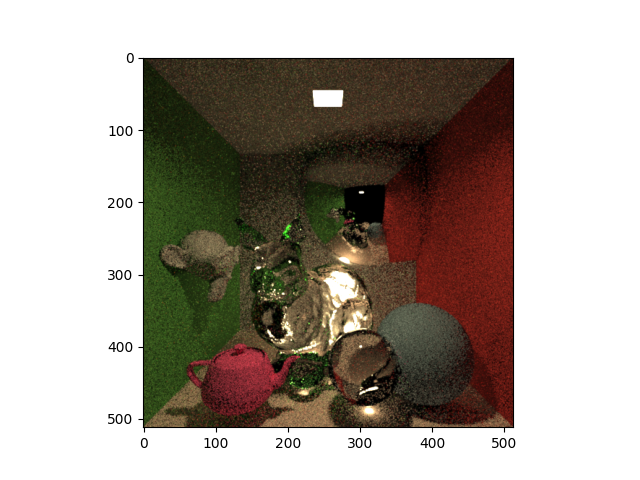

In [7]:
config['integrator'] = {
    'type': 'myintegrator',
    'max_depth': 5,
    'rr_depth': 3,
}

show(config, spp=1000)

In [7]:

class Spot(mi.Emitter):
    def __init__(self, props):
        super().__init__(props)

        # set flags
        self.m_flags = +mi.EmitterFlags.DeltaPosition
        # ---
        self.m_intensity = props.get("intensity", 1.0)

        # setup some other params
        cutoff_angle = props.get("cutoff_angle", 20.0)
        m_beam_width = props.get("beam_width", cutoff_angle * 3.0 / 4.0)
        self.m_cutoff_angle = (180.0/3.14)*(cutoff_angle)
        self.m_beam_width = (180.0/3.14) * (m_beam_width)
        self.m_inv_transition_width = 1.0 / (self.m_cutoff_angle - self.m_beam_width)
        self.m_cos_cutoff_angle = dr.cos(self.m_cutoff_angle)
        self.m_cos_beam_width = dr.cos(self.m_beam_width)
        self.m_uv_factor = dr.tan(self.m_cutoff_angle)

    def is_environment(self: mi.Emitter):
        return False
    
    def sampling_weight(self):
        pass

    def flags(self, active):
        return self.flags

    def falloff_curve(self, d, active):
        local_dir = dr.normalize(d) 
        cos_theta = local_dir.z()
        beam_res = dr.select(
            cos_theta >= self.m_cos_cutoff_angle, 1.0,
            (self.m_cutoff_angle - dr.acos(cos_theta)) * self.m_inv_transition_width
        )

        return dr.select(
            cos_theta > self.m_cos_beam_width, beam_res, 0.0
        )

    def direction_to_uv(self, local_dir):
        return mi.Point2f(
            0.5 + 0.5 * local_dir.x()/ (local_dir.z() * self.m_uv_factor), 
            0.5 + 0.5 * local_dir.y()/ (local_dir.z() * self.m_uv_factor)
        )
    
    def sample_ray(self, time, wv_s, sp_s, dir_s, active):
        print(self.__class__.__name__, "sample_ray", time.__class__.__name__, wv_s.__class__.__name__, sp_s.__class__.__name__, dir_s.__class__.__name__, active.__class__.__name__)
        # sample direction
        local_dir = mi.warp.square_to_uniform_cone(sp_s, self.m_cos_cutoff_angle)
        pdf_dir = mi.warp.square_to_uniform_cone_pdf(local_dir, self.m_cos_cutoff_angle)

        # sample spec
        si = dr.zeros(mi.SurfaceInteraction3f)
        si.time = time
        si.p = self.m_to_world.value().translation()
        si.uv = self.direction_to_uv(local_dir)
        wavelengths, spec_weight = self.sample_wavelengths(si, wv_s, active)

        falloff = self.falloff_curve(local_dir, active)

        return mi.Ray3f(si.p, self.m_to_world * local_dir, time, wavelengths), \
            (spec_weight * falloff / pdf_dir)


    def sample_direction(self, it, sample, active):
        print(self.__class__.__name__, "sample_direction", it.__class__.__name__, sample.__class__.__name__, active.__class__.__name__)
        ds = dr.zeros(mi.DirectionSample3f)
        ds.p = self.m_to_world.translation()
        ds.n = 0.0
        ds.uv = 0.0
        ds.pdf = 1.0
        ds.time = it.time
        ds.delta = True
        ds.emitter = self
        ds.d = ds.p - it.p
        ds.dist = dr.norm(ds.d)
        inv_dist = dr.rcp(ds.dist)
        ds.d *= inv_dist
        local_d = self.m_to_world.inverse() * -ds.d

        falloff = self.falloff_curve(local_d, active)
        active &= falloff > 0.0

        si = dr.zeros(mi.SurfaceInteraction3f)
        si.t = 0.0
        si.time = it.time
        si.wavelengths = it.wavelengths
        si.p = ds.p 
        radiance = self.m_intensity.eval(si, active)

        return ds, (radiance & active ) * (falloff * dr.sqr(inv_dist))

    def pdf_direction(self, it, dir_s, active):
        return 0.0

    def eval_direction(self, it, ds, active):
        pass

    def sample_position(self, time, sample, active):
        center_dir = self.m_to_world * mi.ScalarVector3f(0.0, 0.0, 1.0)
        ps = mi.PositionSample3f(
            self.m_to_world.translation(), center_dir,
            mi.Point2f(0.5), time, 1.0, True
        )   

        return ps, mi.Float(1.0)

    def sample_wavelength(self, si, sample, active):
        # TODO: sample_shifted will not work
        wav, weight = self.m_intensity.sample_spectrum(si, 
                mi.math.sample_shifted(sample), active)
        
        return wav, weight

    def eval(self, si, mask):
        return 0.0
    
    def bbox(self):
        p = self.m_to_world.scalar() * mi.ScalarPoint3f(0.0)
        return mi.BoundingBox3f(p, p)
    
mi.register_emitter("spot", lambda props: Spot(props))

In [8]:
config['light']['emitter'] = {
    'type': 'spot',
}

show(config, spp=1000)

Spot sample_direction Interaction3f Point2f Bool


AttributeError: 'Spot' object has no attribute 'm_to_world'